# **Tarea 11**

## **Ana Isabel Moreno Hernández**

### Análisis de datos

----------------------------------------------------------------------------------------------------------------

**Importamos las librerías necesarias**

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import copy
import numpy as np
from scipy.integrate import trapz, simps
import math
import random
%matplotlib inline

In [2]:
from colossus.cosmology import cosmology

**Inicializamos la clase e imprimimos los parámetros definidos por el experimento Planck:**

In [3]:
cosmo = cosmology.setCosmology('planck15')
print(cosmo)

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0486, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


Cargamos los datos:

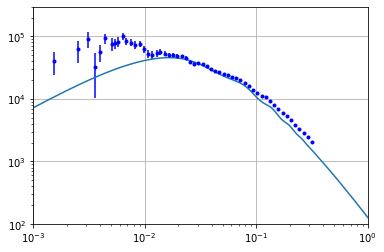

In [5]:
k = 10**np.linspace(-5,6,100000)
Pk = cosmo.matterPowerSpectrum(k,0.57)

pk_cmasdr12 = np.loadtxt('GilMarin_2016_CMASSDR12_measurement_monopole_post_recon.txt').T
plt.figure()
plt.loglog()
plt.errorbar(pk_cmasdr12[0], pk_cmasdr12[1], yerr = pk_cmasdr12[2], fmt = '.b')
plt.plot(k, 1.85**2*Pk, '-')
plt.xlim(1e-3,1)
plt.ylim(100, 3e5)
plt.grid('True')

-----------------------------------------------------------

## **Metrópolis**

**Tenemos un nuevo parámetro $\beta$:**
$P(k) = b^2(1+\beta)P_l(k)$

**A continuación definiremos la función Pk_Om que cambia el parámetro de densidad de materia total y recibe como argumento el nuevo valor de Om0, el valor de la constante $b$ que se eleva al cuadrado y multiplica a la función matterPowerSpectrum y el valor de beta, que es el nuevo parámetro.**

In [6]:
cosmo = cosmology.setCosmology('planck15')
print(cosmo)

def Pk_Om(Om_,b,beta,k):
    cosmo = cosmology.setCosmology('planck15') # Generamos los parámetros default del experimento planck15
    z = 0.57 
    cosmo.Om0 = Om_ # Modificamos la densidad de materia
    return b**2*(1+beta)*cosmo.matterPowerSpectrum(k,z) # Se regresa la función matterPowerSpectrum multiplicada por el bias al cuadrado

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0486, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [7]:
def likelihood(Om, b, beta,data): # Función que calcula el logaritmo natural del likelihood
    equis = data[0] # Llamamos x al primer conjunto de datos
    ye = data[1] # Llamamos y al segundo conjunto de datos
    yerr = data[2]  # Llamamos yerror al tercer conjunto de datos
    model = Pk_Om(Om, b, beta,equis) # Calculamos el modelo utilizando la función Pk_om
    likelihood_0 = (ye-model)**2/(yerr**2)  # Obtenemos chi^2
    return likelihood_0.sum() # Regresamos la suma de todos los chi^2, que da como resultado el ln del likelihood.

**Empezamos con un camino para observar si nuestras funciones se ajustan a los datos. Variamos el parámetro $Om0$ entre 0.1 y 0.5, el bias $b$ entre 1 y 3 y $\beta$ entre 0 y 1.**

In [99]:
np.random.seed(1) # Semilla para los números aleatorios.
x = pk_cmasdr12[0][15:45] # Quitamos los datos del inicio que no se ajustan a ningún modelo del matterPowerSpectrum
y = pk_cmasdr12[1][15:45]
yerror = pk_cmasdr12[2][15:45]

rango = 1500 # Establecemos un rango de 2000

Om_0 = 0.4 # Damos un valor inicial para la densidad de materia
b0 = 2.2 # Valor inicial para el bias
beta0 = 0.5 # Valor inicial para beta
lnlike0 = -1*likelihood(Om_0, b0, beta0,[x,y,yerror]) # Calculamos el logaritmo natural del primer likelihood 

Om_sample = [Om_0] # Guardamos el primer valor de la densidad de mateira
b_sample = [b0] # Guardamos el primer valor del bias
beta_sample = [beta0]

sigma = 0.01 # Establecemos un valor para la desviación estándar de los caminos en el método de metrópolis

for j in range(1,rango):
    Om_new = np.random.normal(Om_sample[len(Om_sample)-1], sigma) # Generamos un valor de densidad de materia nuevo de una probabilidad gaussiana con mediana igual al valor anterior de Om0 y con desviación estándar sigma.
    b_new = np.random.normal(b_sample[len(b_sample)-1], sigma)
    beta_new = np.random.normal(beta_sample[len(b_sample)-1], sigma)
    if Om_new <= 1 and Om_new >= 0.1 and b_new <= 3 and b_new >= 1 and beta_new >=0 and beta_new <=1: # Establecemos el prior
        like = -1*likelihood(Om_new, b_new, beta_new,[x,y,yerror])
        if like>lnlike0: # Si el logaritmo natural del nuevo likelihood es mayor que el anterior, se acepta
            lnlike0 = like
            Om_sample.append(Om_new) # Se guardan los nuevos valores de Om0, b y beta
            b_sample.append(b_new)
            beta_sample.append(beta_new)
        elif lnlike0-like<-1*math.log(random.uniform(0,1)): # Si la diferencia es menor que el negativo del logaritmo de un número aletorio de una distribución uniforme, se acepta.
            lnlike0 = like
            Om_sample.append(Om_new) # Se guardan los nuevos valores de Om0, b y beta
            b_sample.append(b_new)
            beta_sample.append(beta_new)

Text(0.5, 0, '$beta$')

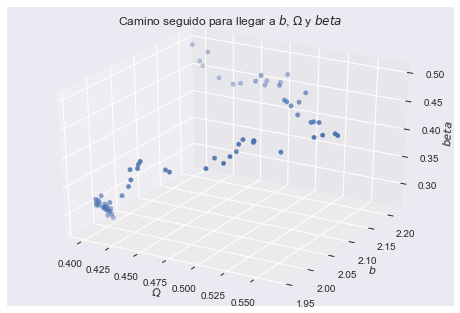

In [100]:
from mpl_toolkits.mplot3d import axes3d
plt.style.use('seaborn')

fig = plt.figure()
ax1 = fig.add_subplot(111,projection='3d')

ax1.scatter(Om_sample, b_sample, beta_sample)
ax1.set_title('Camino seguido para llegar a $b$, $\Omega$ y $beta$')
ax1.set_xlabel('$\Omega$')
ax1.set_ylabel('$b$')
ax1.set_zlabel('$beta$')

In [101]:
len(b_sample)

69

**Ahora observamos las distribuciones de los parámetros:**

Text(0, 0.5, 'Frecuencia')

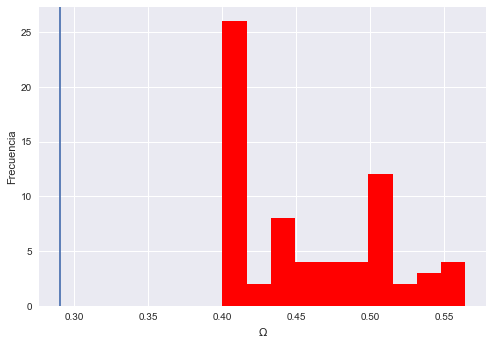

In [102]:
plt.hist(Om_sample, color = 'red')
plt.axvline(0.29)
plt.xlabel('$\Omega$')
plt.ylabel('Frecuencia')

Text(0, 0.5, 'Frecuencia')

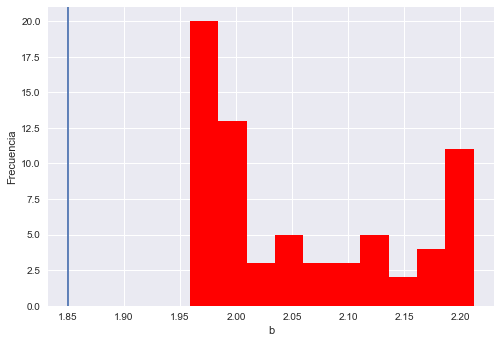

In [103]:
plt.hist(b_sample, color = 'red')
plt.axvline(1.85)
plt.xlabel('b')
plt.ylabel('Frecuencia')

Text(0, 0.5, 'Frecuencia')

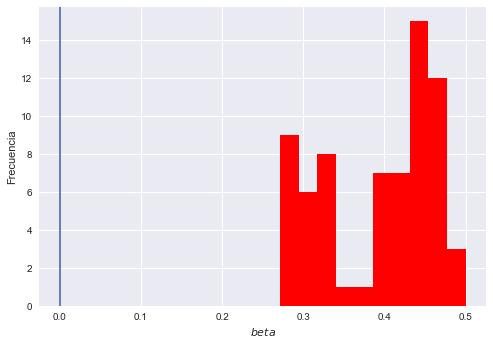

In [104]:
plt.hist(beta_sample, color = 'red')
plt.axvline(0)
plt.xlabel('$beta$')
plt.ylabel('Frecuencia')

In [105]:
Om0 = np.median(Om_sample)
be = np.median(b_sample)
beta = np.median(beta_sample)

Text(0, 0.5, 'P(k)')

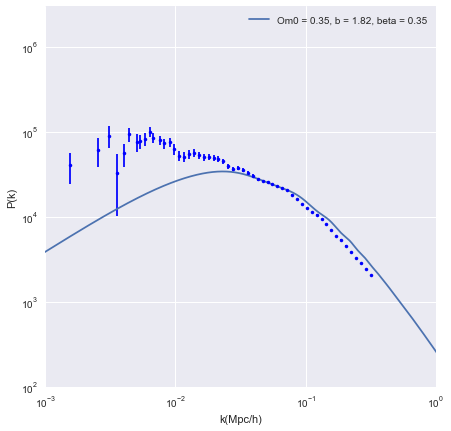

In [106]:
plt.figure(figsize = (7,7))
plt.loglog()

k = 10**np.linspace(-5,6,100000)
cosmo.Om0 = Om0
Pk = be**2*(1+beta)*cosmo.matterPowerSpectrum(k,0.57)

plt.plot(k,Pk, '-', label = 'Om0 = 0.35, b = 1.82, beta = 0.35') # Con bias
plt.errorbar(pk_cmasdr12[0], pk_cmasdr12[1], yerr = pk_cmasdr12[2], fmt = '.b')
  
plt.xlim(1e-3,1)
plt.ylim(100,3e6)
plt.legend()
plt.xlabel('k(Mpc/h)')
plt.ylabel('P(k)')

**Ahora utilizamos varios caminos:**

In [ ]:
np.random.seed(1) # Semilla para los números aleatorios.
x = pk_cmasdr12[0][15:45] # Quitamos los datos del inicio que no se ajustan a ningún modelo del matterPowerSpectrum
y = pk_cmasdr12[1][15:45]
yerror = pk_cmasdr12[2][15:45]

Om_total = [] # Declaramos Om_total, que es donde se guardarán los valores de Om0 para cada camino
b_total = [] # Lo mismo para el bias. 
beta_total = []

sigma = 0.01 # Desviación estándar de la distribución gaussiana de números aleatorios.
rango = 4000

for k in range(10): # 10 caminos
    Om_0 = np.random.uniform(0.1, 0.5, 10) # Los valores iniciales para cada camino se generarán con números aleatorios de una distribución uniforme
    b0 = np.random.uniform(1.5, 2.2, 10) # Lo mismo para el bias
    beta0 = np.random.uniform(0, 0.5, 10) # Lo mismo para beta
    Om_sample = [Om_0[k]] # Guardamos el valor inicial para Om0 del camino k
    b_sample = [b0[k]] # Guardamos el valor inicial para el bias del camino k
    beta_sample = [beta0[k]] # Guardamos el valor inicial para el Beta del camino k
    lnlike0 = -1*likelihood(Om_0[k], b0[k], beta0[k],[x,y,yerror]) # Calculamos el logaritmo natural del likelihood inicial para cada camino
    for j in range(1,rango):
        Om_new = np.random.normal(Om_sample[len(Om_sample)-1], sigma) # Obtenemos un nuevo valor para Om0
        b_new = np.random.normal(b_sample[len(b_sample)-1], sigma) # Obtenemos un nuevo valor para b
        beta_new = np.random.normal(beta_sample[len(beta_sample)-1], sigma) # Obtenemos un nuevo valor para beta
        if Om_new <= 0.5 and Om_new >= 0.1 and b_new <= 2.2 and b_new >= 1.5 and beta_new >= 0 and beta_new <=0.5: # Prior
            like = -1*likelihood(Om_new, b_new, beta_new,[x,y,yerror]) # Prior
            if like>lnlike0: # Si el nuevo ln de L es mayor que el anterior, se acepta
                lnlike0 = like
                Om_sample.append(Om_new) # Se guarda el nuevo valor de Om0 para el camino k
                b_sample.append(b_new) # Lo mismo para b
                beta_sample.append(beta_new)
            elif lnlike0-like<-math.log(random.uniform(0,1)): # Si la diferencia es menor que el logaritmo de un número aleatorio en 0 y 1 se acepta
                lnlike0 = like 
                Om_sample.append(Om_new) # Se guarda el nuevo valor de Om0 para el camino k
                b_sample.append(b_new) # Lo mismo para b
                beta_sample.append(beta_new)
    Om_total.append(Om_sample) # Se guardan los valores de Om0 del camino k en m_total
    b_total.append(b_sample)
    beta_total.append(beta_sample)

Text(0.5, 0, '$beta$')

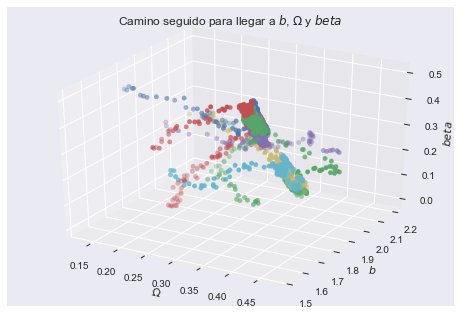

In [30]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax1 = fig.add_subplot(111,projection='3d')

for i in range(len(Om_total)):
    ax1.scatter(Om_total[i], b_total[i], beta_total[i])


ax1.set_title('Camino seguido para llegar a $b$, $\Omega$ y $beta$')
ax1.set_xlabel('$\Omega$')
ax1.set_ylabel('$b$')
ax1.set_zlabel('$beta$')    

**Observamos las distribuciones de los parámetros quitando el burning.**

Quitamos el burning:

In [31]:
Om_new = []
b_new = []
beta_new = []

burn = 150
for i in range(len(Om_total)):
    if(len(Om_total[i])>burn and len(b_total[i])>burn and len(beta_total[i])):
        Om_new.append(Om_total[i][burn:])
        b_new.append(b_total[i][burn:])
        beta_new.append(beta_total[i][burn:])

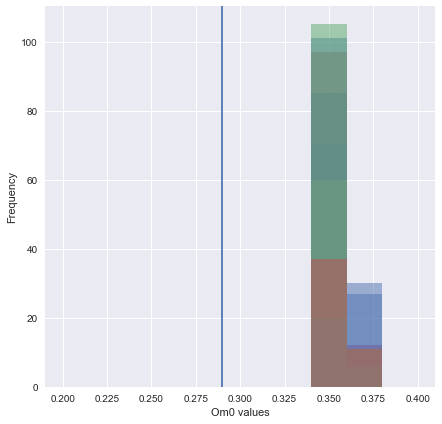

In [32]:
plt.figure(figsize = (7,7))
for i in range(len(Om_new)):
    plt.hist(Om_new[i], range = (0.2,0.4),alpha = 0.5)

plt.axvline(0.29)
plt.xlabel('Om0 values')
plt.ylabel('Frequency');

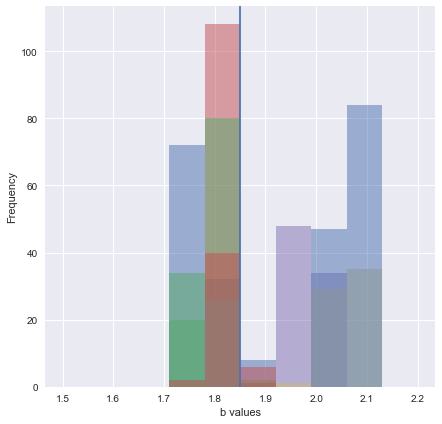

In [33]:
plt.figure(figsize = (7,7))
for i in range(len(b_new)):
    plt.hist(b_new[i], range = (1.5,2.2),alpha = 0.5)

plt.axvline(1.85)
plt.xlabel('b values')
plt.ylabel('Frequency');

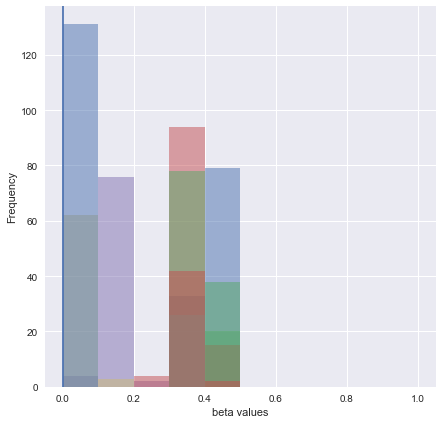

In [34]:
plt.figure(figsize = (7,7))
for i in range(len(beta_new)):
    plt.hist(beta_new[i], range = (0.0,1.0),alpha = 0.5)

plt.axvline(0)
plt.xlabel('beta values')
plt.ylabel('Frequency');

**Observamos la dispersión**

Text(0.5, 0, '$beta$')

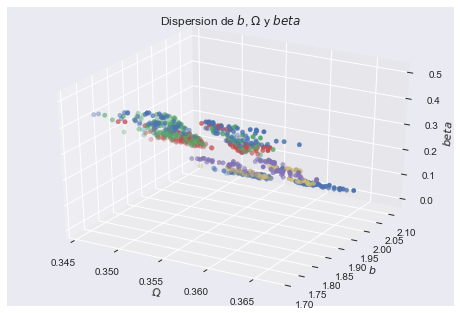

In [35]:
plt.style.use('seaborn')
fig = plt.figure()
ax1 = fig.add_subplot(111,projection='3d')

for i in range(len(Om_new)):
    ax1.scatter(Om_new[i], b_new[i], beta_new[i])

    
ax1.set_title('Dispersion de $b$, $\Omega$ y $beta$')
ax1.set_xlabel('$\Omega$')
ax1.set_ylabel('$b$')
ax1.set_zlabel('$beta$')   

**Usamos el método de Gelman-Rubin para determinar si las cadenas han convergido. Referencia: https://arxiv.org/pdf/1812.09384.pdf**

In [36]:
n = 5 # Número de caminos

def prom_x_i(x_it):
    return np.mean(x_it) # Promedio de un camino

def prom_mu(x_i):
    sum = 0
    for i in range(n):
        sum = sum + prom_x_i(x_i[i]) # Promedio de todos los caminos
    return sum/n

def s_i2(x_it):
    return np.std(x_it) # Desviación estándar de un camino

def s2(x_i):
    sum = 0
    for i in range(n):
        sum = sum + s_i2(x_i[i]) # Desviación estándar de todos los caminos
    return sum/n

def B_n(x_i): # Parámetro Bn
    sum = 0
    for i in range(n):
        sum = sum + (prom_x_i(x_i[i])-prom_mu(x_i))**2
    return sum/(n-1)

def sigma_gorro2(x_i, m):  
    return (m-1)*s2(x_i)/m + B_n(x_i)

def R(x_i, m): # Parámetro R
    return math.sqrt(sigma_gorro2(x_i, m)/s2(x_i))

In [37]:
len(Om_new) # Vemos cuántos caminos tienen más de 100 puntos

9

In [38]:
n = len(Om_new)
R(Om_new, len(Om_new[0]))

0.9955886469190375

In [39]:
R(b_new, len(b_new[0]))

1.3302579012981233

In [40]:
R(beta_new, len(b_new[0]))

1.3962381778836517

**Calculamos las medianas**

In [41]:
from statistics import median

In [42]:
mediana0 = []

for i in range(len(Om_new)):
    mediana0.append(np.median(Om_new[i]))

In [43]:
medianab = []

for i in range(len(b_new)):
    medianab.append(np.median(b_new[i]))

In [44]:
medianabeta = []

for i in range(len(beta_new)):
    medianabeta.append(np.median(beta_new[i]))

In [45]:
Om0 = median(mediana0)
be = median(medianab)
beta = median(medianabeta)
print(Om0, be, beta)

0.3550870260136979 1.8168055650206927 0.35744894913944514


**Vemos cómo nuestros caminos convergen al mismo valor:**

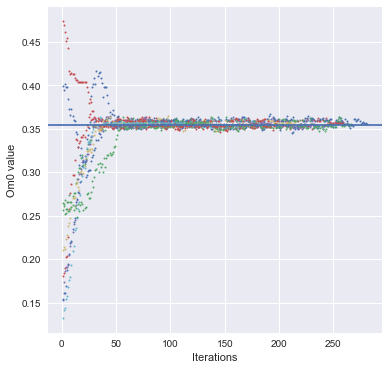

In [46]:
plt.figure(figsize = (6,6))

for i in range(1,len(Om_total)):
    iteraciones = np.linspace(1, len(Om_total[i]), len(Om_total[i]))
    plt.plot(iteraciones, Om_total[i], 'o', markersize = 2)


plt.grid('True')
plt.xlabel('Iterations')
plt.axhline(Om0)
plt.ylabel('Om0 value');

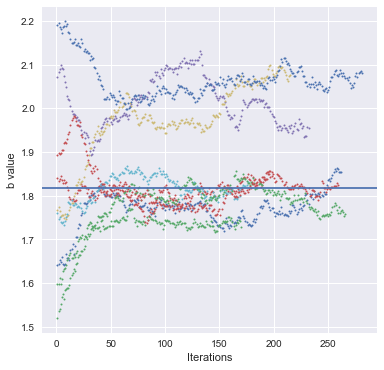

In [47]:
plt.figure(figsize = (6,6))

for i in range(1,len(b_total)):
    iteraciones = np.linspace(1, len(b_total[i]), len(b_total[i]))
    plt.plot(iteraciones, b_total[i], 'o', markersize = 2)


plt.grid('True')
plt.xlabel('Iterations')
plt.axhline(be)
plt.ylabel('b value');

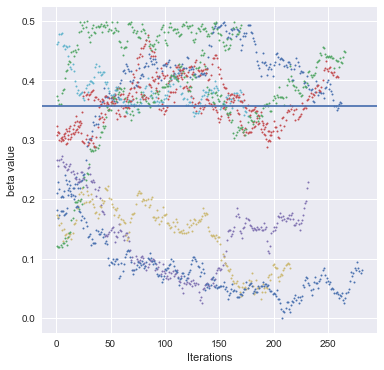

In [48]:
plt.figure(figsize = (6,6))

for i in range(1,len(beta_total)):
    iteraciones = np.linspace(1, len(beta_total[i]), len(beta_total[i]))
    plt.plot(iteraciones, beta_total[i], 'o', markersize = 2)


plt.grid('True')
plt.xlabel('Iterations')
plt.axhline(beta)
plt.ylabel('beta value');

**Finalmente graficamos y vemos qué tan bien nuestro modelo se ajusta a los datos**

Text(0, 0.5, 'P(k)')

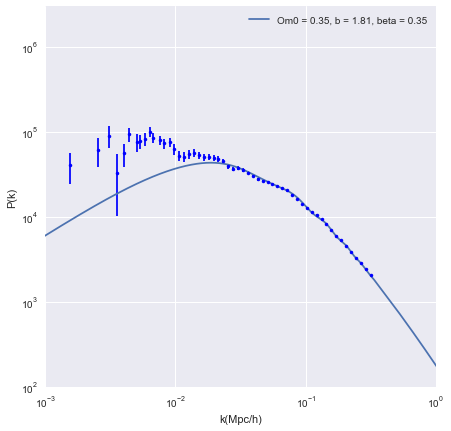

In [49]:
plt.figure(figsize = (7,7))
plt.loglog()

k = 10**np.linspace(-5,6,100000)
cosmo.Om0 = Om0
Pk = be**2*(1+beta)*cosmo.matterPowerSpectrum(k,0.57)

plt.plot(k,Pk, '-', label = 'Om0 = 0.35, b = 1.81, beta = 0.35') # Con bias
plt.errorbar(pk_cmasdr12[0], pk_cmasdr12[1], yerr = pk_cmasdr12[2], fmt = '.b')
  
plt.xlim(1e-3,1)
plt.ylim(100,3e6)
plt.legend()
plt.xlabel('k(Mpc/h)')
plt.ylabel('P(k)')

------------------------------------------

## **Nuevo modelo en Metrópolis**

**Ahora intentaremos ajustar utilizando el siguiente modelo:** 
$P(k) = b^2(1+\frac{\Omega^{0.55}_{m,0}}{b})P_L(k, \Omega_{m,0})$

In [241]:
cosmo = cosmology.setCosmology('planck15')
print(cosmo)

def Pk_Om(Om_,b,k):
    cosmo = cosmology.setCosmology('planck15') # Generamos los parámetros default del experimento planck15
    z = 0.57 
    cosmo.Om0 = Om_ # Modificamos la densidad de materia
    return b**2*(1+(Om_**0.55/b))*cosmo.matterPowerSpectrum(k,z) # Se regresa la función matterPowerSpectrum multiplicada por el bias al cuadrado

def likelihood(Om, b, data): # Función que calcula el logaritmo natural del likelihood
    equis = data[0] # Llamamos x al primer conjunto de datos
    ye = data[1] # Llamamos y al segundo conjunto de datos
    yerr = data[2]  # Llamamos yerror al tercer conjunto de datos
    model = Pk_Om(Om, b, equis) # Calculamos el modelo utilizando la función Pk_om
    likelihood_0 = (ye-model)**2/(yerr**2)  # Obtenemos chi^2
    return likelihood_0.sum() # Regresamos la suma de todos los chi^2, que da como resultado el ln del likelihood.

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0486, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


**Varios caminos**

In [242]:
np.random.seed(1) # Semilla para los números aleatorios.
x = pk_cmasdr12[0][15:45] # Quitamos los datos del inicio que no se ajustan a ningún modelo del matterPowerSpectrum
y = pk_cmasdr12[1][15:45]
yerror = pk_cmasdr12[2][15:45]

Om_total = [] # Declaramos Om_total, que es donde se guardarán los valores de Om0 para cada camino
b_total = [] # Lo mismo para el bias. 

sigma = 0.01 # Desviación estándar de la distribución gaussiana de números aleatorios.
rango = 3000

for k in range(10): # 10 caminos
    Om_0 = np.random.uniform(0.1, 0.7, 10) # Los valores iniciales para cada camino se generarán con números aleatorios de una distribución uniforme
    b0 = np.random.uniform(1.3, 2.3, 10) # Lo mismo para el bias
    Om_sample = [Om_0[k]] # Guardamos el valor inicial para Om0 del camino k
    b_sample = [b0[k]] # Guardamos el valor inicial para el bias del camino k
    lnlike0 = -1*likelihood(Om_0[k], b0[k], [x,y,yerror]) # Calculamos el logaritmo natural del likelihood inicial para cada camino
    for j in range(1,rango):
        Om_new = np.random.normal(Om_sample[len(Om_sample)-1], sigma) # Obtenemos un nuevo valor para Om0
        b_new = np.random.normal(b_sample[len(b_sample)-1], sigma) # Obtenemos un nuevo valor para b
        if Om_new <= 0.7 and Om_new >= 0.1 and b_new <= 2.3 and b_new >= 1.3: # Prior
            like = -1*likelihood(Om_new, b_new, [x,y,yerror]) # Prior
            if like>lnlike0: # Si el nuevo ln de L es mayor que el anterior, se acepta
                lnlike0 = like
                Om_sample.append(Om_new) # Se guarda el nuevo valor de Om0 para el camino k
                b_sample.append(b_new) # Lo mismo para b
            elif lnlike0-like<-math.log(random.uniform(0,1)): # Si la diferencia es menor que el logaritmo de un número aleatorio en 0 y 1 se acepta
                lnlike0 = like 
                Om_sample.append(Om_new) # Se guarda el nuevo valor de Om0 para el camino k
                b_sample.append(b_new) # Lo mismo para b
    Om_total.append(Om_sample) # Se guardan los valores de Om0 del camino k en m_total
    b_total.append(b_sample)

**Observamos el camino seguido para llegar a los valores de $\Omega$ y $b$**

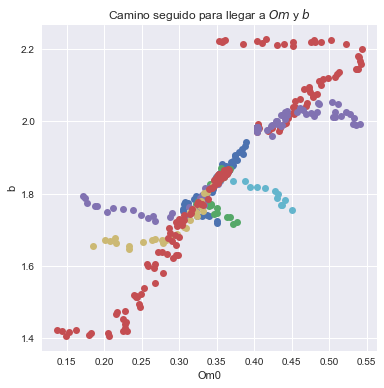

In [243]:
plt.figure(figsize = (6,6))
for k in range(10):
    plt.plot(Om_total[k],b_total[k], 'o')
    

plt.xlabel('Om0')
plt.ylabel('b')
plt.title('Camino seguido para llegar a $Om$ y $b$')
plt.grid('True')

**Quitamos el burning**

In [244]:
Om_new = []
b_new = []

burn = 100
for i in range(10):
    if(len(Om_total[i])>burn and len(b_total[i])>burn):
        Om_new.append(Om_total[i][burn:])
        b_new.append(b_total[i][burn:])

In [245]:
len(Om_new) # Vemos cuántos caminos tienen más de 100 puntos

8

**Utilizamos el método de Gelman-Rubin para determinar si nuestras cadenas han convergido.**

In [246]:
n = len(Om_new)
R(Om_new, len(Om_new[0]))

0.996349915798532

In [247]:
R(b_new, len(b_new[0]))

0.9963928643308522

**Observamos distribuciones sin el burning**

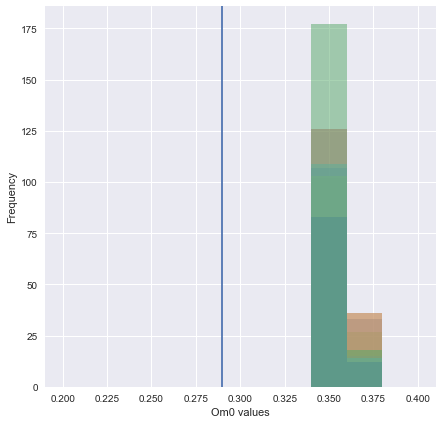

In [248]:
plt.figure(figsize = (7,7))
for i in range(len(Om_new)):
    plt.hist(Om_new[i], range = (0.2,0.4),alpha = 0.5)

plt.axvline(0.29)
plt.xlabel('Om0 values')
plt.ylabel('Frequency');

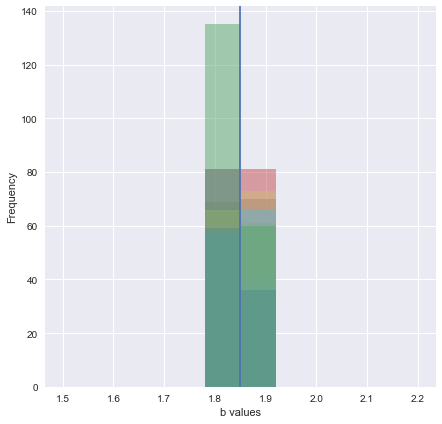

In [249]:
plt.figure(figsize = (7,7))
for i in range(len(b_new)):
    plt.hist(b_new[i], range = (1.5,2.2),alpha = 0.5)

plt.axvline(1.85)
plt.xlabel('b values')
plt.ylabel('Frequency');

**Ahora observamos la dispersión de los valores.**

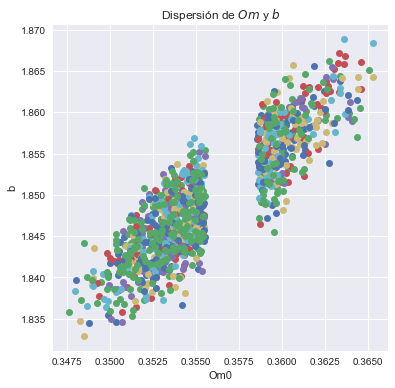

In [250]:
plt.figure(figsize = (6,6))
for k in range(len(b_new)):
    plt.plot(Om_new[k],b_new[k], 'o')
    

plt.xlabel('Om0')
plt.ylabel('b')
plt.title('Dispersión de $Om$ y $b$')
plt.grid('True')

**Calculamos las medianas.**

In [251]:
mediana0 = []

for i in range(len(Om_new)):
    mediana0.append(np.median(Om_new[i]))

In [252]:
medianab = []

for i in range(len(b_new)):
    medianab.append(np.median(b_new[i]))

**Imprimimos los valores de las medianas**

In [253]:
Om0 = median(mediana0)
be = median(medianab)
print(be, Om0)

1.8497581611314415 0.3549483811542493


Y observamos cómo nuestros caminos convergen a estos valores. 

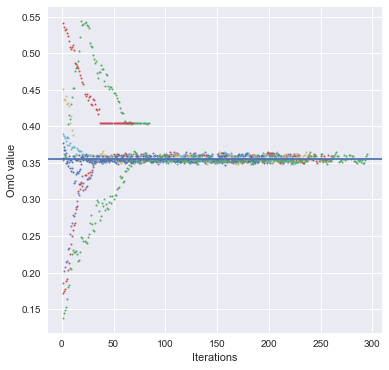

In [254]:
plt.figure(figsize = (6,6))

for i in range(1,len(Om_total)):
    iteraciones = np.linspace(1, len(Om_total[i]), len(Om_total[i]))
    plt.plot(iteraciones, Om_total[i], 'o', markersize = 2)


plt.grid('True')
plt.xlabel('Iterations')
plt.axhline(Om0)
plt.ylabel('Om0 value');

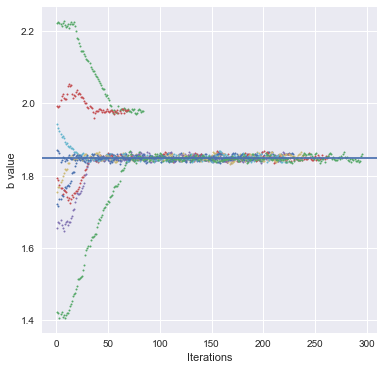

In [255]:

plt.figure(figsize = (6,6))

for i in range(1,len(b_total)):
    iteraciones = np.linspace(1, len(b_total[i]), len(b_total[i]))
    plt.plot(iteraciones, b_total[i], 'o', markersize = 2)


plt.grid('True')
plt.xlabel('Iterations')
plt.axhline(be)
plt.ylabel('b value');

**Finalmente graficamos y vemos qué tan bien nuestro modelo se ajusta a los datos.**

Text(0, 0.5, 'P(k)')

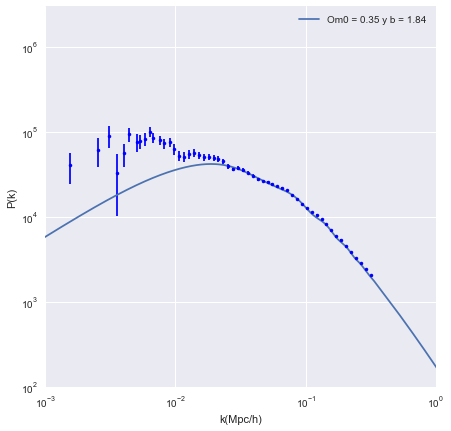

In [50]:
plt.figure(figsize = (7,7))
plt.loglog()

k = 10**np.linspace(-5,6,100000)
cosmo.Om0 = Om0
Pk = be**2*(1+(Om0**0.55)/be)*cosmo.matterPowerSpectrum(k,0.57)

plt.plot(k,Pk, '-', label = 'Om0 = 0.35 y b = 1.84') # Con bias
plt.errorbar(pk_cmasdr12[0], pk_cmasdr12[1], yerr = pk_cmasdr12[2], fmt = '.b')
  
plt.xlim(1e-3,1)
plt.ylim(100,3e6)
plt.legend()
plt.xlabel('k(Mpc/h)')
plt.ylabel('P(k)')